In [1]:
import glob
import os
from astropy.io import fits
from astropy import units as u
from higal_sedfitter import smooth, fit, higal_beams
from higal_sedfitter.fit import PixelFitter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from lmfit import minimize, Parameters, Model
import FITS_tools.header_tools as FITS_header_tools
import aplpy as ap
import shutil
from astropy.table import Table, Column, vstack
import astropy.coordinates as coords
import astropy.constants as cons
from scipy.integrate import quad

In [2]:
pwd = os.getcwd()
print(pwd)

/home/wang/casa/LIu


In [3]:
Herschel1="Herschel_PACS070.fits"
hdu = fits.open(Herschel1)
fits.writeto("Herschel_PACS070_newhd.fits",header=hdu[1].header, data=hdu[1].data, overwrite=True)

In [4]:
Herschel2="Herschel_PACS160.fits"
hdu = fits.open(Herschel2)
fits.writeto("Herschel_PACS160_newhd.fits",header=hdu[1].header, data=hdu[1].data, overwrite=True)
Herschel3="Herschel_SPIRE250.fits"
hdu = fits.open(Herschel3)
fits.writeto("Herschel_SPIRE250_newhd.fits",header=hdu[1].header, data=hdu[1].data, overwrite=True)
Herschel4="Herschel_SPIRE350.fits"
hdu = fits.open(Herschel4)
fits.writeto("Herschel_SPIRE350_newhd.fits",header=hdu[1].header, data=hdu[1].data, overwrite=True)
Herschel5="Herschel_SPIRE500.fits"
hdu = fits.open(Herschel5)
fits.writeto("Herschel_SPIRE500_newhd.fits",header=hdu[1].header, data=hdu[1].data, overwrite=True)

In [5]:
fn='Herschel_PACS070_newhd.fits'
smooth.add_beam_information_to_higal_header(fn, name_to_um=higal_beams.num_to_um, clobber=True)
fn1='Herschel_PACS160_newhd.fits'
smooth.add_beam_information_to_higal_header(fn1, name_to_um=higal_beams.num_to_um, clobber=True)
fn2='Herschel_SPIRE250_newhd.fits'
smooth.add_beam_information_to_higal_header(fn2, name_to_um=higal_beams.num_to_um, clobber=True)
fn3='Herschel_SPIRE350_newhd.fits'
smooth.add_beam_information_to_higal_header(fn3, name_to_um=higal_beams.num_to_um, clobber=True)
fn4="Herschel_SPIRE500_newhd.fits"
smooth.add_beam_information_to_higal_header(fn4, name_to_um=higal_beams.num_to_um, clobber=True)

In [6]:
bmaj = np.array(
        [FITS_header_tools.header_to_platescale(fits.open('Herschel_PACS070_newhd.fits')[0].header,use_units=True).value,
        FITS_header_tools.header_to_platescale(fits.open('Herschel_PACS160_newhd.fits')[0].header,use_units=True).value,
        fits.getheader('Herschel_SPIRE250_newhd.fits')['BMAJ'],
        fits.getheader('Herschel_SPIRE350_newhd.fits')['BMAJ'],
        fits.getheader('Herschel_SPIRE500_newhd.fits')['BMAJ'],
        fits.getheader('Apex_ATLASGAL870.fits')['BMAJ']])
bmin = np.array(
        [FITS_header_tools.header_to_platescale(fits.open('Herschel_PACS070_newhd.fits')[0].header,use_units=True).value,
        FITS_header_tools.header_to_platescale(fits.open('Herschel_PACS160_newhd.fits')[0].header,use_units=True).value,
        fits.getheader('Herschel_SPIRE250_newhd.fits')['BMIN'],
        fits.getheader('Herschel_SPIRE350_newhd.fits')['BMIN'],
        fits.getheader('Herschel_SPIRE500_newhd.fits')['BMIN'],
        fits.getheader('Apex_ATLASGAL870.fits')['BMIN']])

In [7]:
beam_factor = bmaj*bmin*3600**2*np.array([2.35E-5,2.35E-5,2.66E-5,2.66E-5,2.66E-5,2.66E-5])
beam_factor_dir = {'070':beam_factor[0],'160':beam_factor[1],'250':beam_factor[2],
                   '350':beam_factor[3],'500':beam_factor[4],'870':beam_factor[5]}

In [8]:
hdu = fits.open('Herschel_PACS070_newhd.fits')
fits.writeto('Herschel_PACS070_converted.fits', 
              header=hdu[0].header, data=hdu[0].data/beam_factor_dir['070'], overwrite=True)
hdu1 = fits.open('Herschel_PACS160_newhd.fits')
fits.writeto('Herschel_PACS160_converted.fits', 
              header=hdu1[0].header, data=hdu1[0].data/beam_factor_dir['160'], overwrite=True)
hdu2 = fits.open('Herschel_SPIRE250_newhd.fits')
fits.writeto('Herschel_SPIRE250_converted.fits', 
              header=hdu2[0].header, data=hdu2[0].data/beam_factor_dir['250'], overwrite=True)
hdu3 = fits.open('Herschel_SPIRE350_newhd.fits')
fits.writeto('Herschel_SPIRE350_converted.fits', 
              header=hdu3[0].header, data=hdu3[0].data/beam_factor_dir['350'], overwrite=True)
hdu4 = fits.open('Herschel_SPIRE500_newhd.fits')
fits.writeto('Herschel_SPIRE500_converted.fits', 
              header=hdu4[0].header, data=hdu4[0].data/beam_factor_dir['500'], overwrite=True)
hdu5 = fits.open('Apex_ATLASGAL870.fits')
fits.writeto('Apex_ATLASGAL870_converted.fits',
              header=hdu5[0].header, data=hdu5[0].data/beam_factor_dir['870'], overwrite=True)

In [9]:
target_fn = glob.glob('Herschel_SPIRE500_converted.fits')[0]
target_header = fits.getheader(target_fn)

In [10]:
smooth.smooth_images_toresolution(45*u.arcsec, skip_existing=False,
                                  globs=['*_converted.fits'],
                                  regrid=True,
                                  target_header=target_header, clobber=True)

Reading file Herschel_SPIRE350_converted.fits
Convolving with 1.3729819523537996-pixel kernel
Regridding Herschel_SPIRE350_converted_smooth45.fits to Herschel_SPIRE350_converted_smregrid45.fits
Reading file Herschel_SPIRE500_converted.fits
Convolving with 0.313120387820037-pixel kernel
Regridding Herschel_SPIRE500_converted_smooth45.fits to Herschel_SPIRE500_converted_smregrid45.fits
Reading file Herschel_SPIRE250_converted.fits
Convolving with 2.6986208048260547-pixel kernel
Regridding Herschel_SPIRE250_converted_smooth45.fits to Herschel_SPIRE250_converted_smregrid45.fits
Reading file Herschel_PACS160_converted.fits
Convolving with 5.679762023399851-pixel kernel


Regridding Herschel_PACS160_converted_smooth45.fits to Herschel_PACS160_converted_smregrid45.fits
Reading file Herschel_PACS070_converted.fits
Convolving with 5.800520356684337-pixel kernel
Regridding Herschel_PACS070_converted_smooth45.fits to Herschel_PACS070_converted_smregrid45.fits
Reading file Apex_ATLASGAL870_converted.fits
Convolving with 5.004057589034037-pixel kernel
Regridding Apex_ATLASGAL870_converted_smooth45.fits to Apex_ATLASGAL870_converted_smregrid45.fits


In [11]:
wavLower = 1*u.um
wavUpper = 3000*u.um
freqLower = wavUpper.to(u.Hz, u.spectral()).value
freqUpper = wavLower.to(u.Hz, u.spectral()).value

In [12]:
iNh2 = 1.0E+22 # in cm^-2
iTdust = 22.0 # in K.
ibeta = 2.0 # 
betaVary = False # If True, Beta will be fitted. If False, beta will be fixed.
betaMin = 1.0
betaMax = 3.0

In [13]:
wavelengths = np.array([70,160,250,350,500,870])*u.um
frequencies = wavelengths.to(u.Hz, u.spectral()).value.copy()

In [14]:
h = cons.h.cgs.value   # Planck constant in CGS unit
k = cons.k_B.cgs.value # Boltzmann constant in CGS unit
c = cons.c.cgs.value # speed of light in CGS unit
mH = cons.m_p.cgs.value # mass of an neutron
muh2 = 2.8 # mean molecular weight adopted from Kauffmann et al. (2008)
rGD = 100.0 # gas-to-dust mass ratio
nu0 = 599.584916E9 # Reference frequency in Hz.
kappa0 = 5.0/1.5 # Dust emissivity at reference frequency

In [15]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy import units as u
import astropy.coordinates as coords
import astropy.constants as cons
from lmfit import minimize, Parameters, Model

In [16]:
def greybody(nu, nH2=iNh2, Tdust=iTdust, beta=ibeta):
    blackBody = 2*h*nu**3/c**2/(np.exp(h*nu/k/Tdust)-1)
    tau = muh2*mH*nH2*kappa0*(nu/nu0)**beta/rGD
    return blackBody*(1-np.exp(-tau))

In [17]:
gMod = Model(greybody)
gMod.set_param_hint('beta', min = betaMin, max = betaMax, vary = betaVary)
gMod.set_param_hint('Tdust',  max = 80.0)
pars = gMod.make_params()

In [18]:
hdrRaw = fits.getheader('Herschel_PACS160_converted_smregrid45.fits') 
hdrNh2 = hdrRaw.copy()
hdrInt = hdrRaw.copy()
hdrTdust = hdrRaw.copy()
hdrNh2['BUNIT'] = 'cm^-2'
hdrInt['BUNIT'] = 'g s^-3'
hdrTdust['BUNIT'] = 'K'

In [19]:
data070 = fits.getdata('Herschel_PACS070_converted_smregrid45.fits')
data160 = fits.getdata('Herschel_PACS160_converted_smregrid45.fits')
data250 = fits.getdata('Herschel_SPIRE250_converted_smregrid45.fits')
data350 = fits.getdata('Herschel_SPIRE350_converted_smregrid45.fits')
data500 = fits.getdata('Herschel_SPIRE500_converted_smregrid45.fits')
data870 = fits.getdata('Apex_ATLASGAL870_converted_smregrid45.fits')

In [20]:
weis = 1.0*u.MJy/u.sr
dataNh2 = data500.copy()
dataTdust = data500.copy()
dataIntegrate = data500.copy()

In [21]:
for iCol in range(len(data500[:,1])):
    for iRow in range(len(data500[1,:])):
        data = np.array([data070[iCol,iRow], data160[iCol,iRow], data250[iCol,iRow], 
                         data350[iCol,iRow], data500[iCol,iRow], data870[iCol,iRow]])*u.MJy/u.sr
        if ((data070[iCol,iRow] > 0)
            and (data160[iCol,iRow] > 0)
            and (data250[iCol,iRow] > 0) 
            and (data350[iCol,iRow] > 0) 
            and (data500[iCol,iRow] > 0)
            and (data870[iCol,iRow] > 0)):
            sedResult = gMod.fit(data.cgs.value, nu = frequencies, weights = weis.cgs.value)
            inTSED = quad(greybody, freqLower, freqUpper, 
                          args = (sedResult.params['nH2'].value, sedResult.params['Tdust'].value, 
                                  sedResult.params['beta'].value))
            dataNh2[iCol,iRow] = sedResult.params['nH2'].value
            dataTdust[iCol,iRow] = sedResult.params['Tdust'].value
            dataIntegrate[iCol,iRow] = inTSED[0]
        else:
            dataNh2[iCol,iRow] = np.nan
            dataTdust[iCol,iRow] = np.nan
            dataIntegrate[iCol,iRow] = np.nan

In [22]:
fits.writeto('Nh2.fits', data = dataNh2, 
    header = hdrNh2, clobber = True)
fits.writeto('Tdust.fits', data = dataTdust, 
    header = hdrTdust, clobber = True)
fits.writeto('intSED.fits', data = dataIntegrate, 
    header = hdrInt, clobber = True)
stop = time.time()

In [28]:
def plot_result(parameter, distance, sourcename, center_x, center_y, crop_size=0.08, recenter=True, add_grid=True,
                add_beam=True, beam_size=True, add_scalebar=True):
    parameter_dir = {'Tdust': 'Tdust.fits', 'Nh2':'Nh2.fits', 'intSED':'intSED.fits'}
    img = ap.FITSFigure(parameter_dir[parameter])
    img.show_colorscale(stretch='log',cmap='hot')
    img.add_colorbar()
    img.colorbar.set_width(0.4)
    if recenter:
        img.recenter(x=center_x, y=center_y, width=crop_size, height=crop_size)
    if add_grid:
        img.add_grid()
    if add_beam:
        img.add_beam(color='black',hatch='',linewidth=3, alpha=0.1)
        img.beam.set_edgecolor('white')
        img.add_label(0.1,0.15,'beam size',relative='axes',color='k',fontsize=15)
    if add_scalebar:
        img.add_scalebar(0.2*u.pc/(distance*10**3*u.pc)*180/np.pi*u.deg, corner='top left',color='white')
        img.scalebar.set_label('2 pc')
    img.set_title(parameter+' distribution of '+sourcename)
    img.savefig('Tdust.png',dpi=600)

INFO: Auto-setting vmin to  4.099e+21 [aplpy.core]
INFO: Auto-setting vmax to  6.407e+22 [aplpy.core]


/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


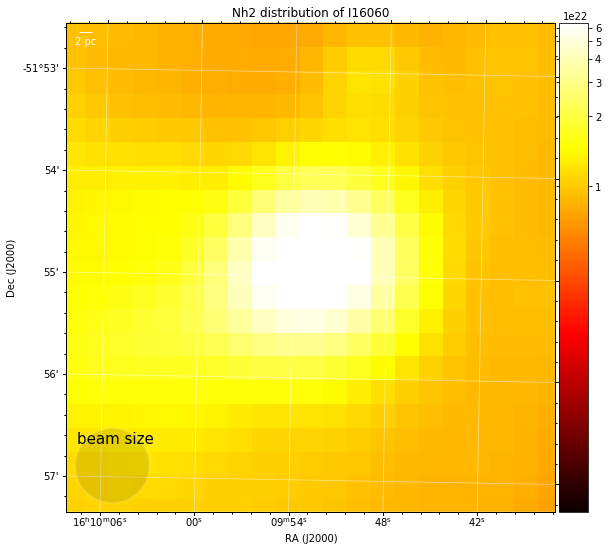

In [30]:
# plot the result
plot_result('Nh2',5.3, 'I16060', center_x=242.4702081, center_y=-51.915194)


INFO: Auto-setting vmin to  4.099e+21 [aplpy.core]
INFO: Auto-setting vmax to  6.407e+22 [aplpy.core]


/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/wang/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


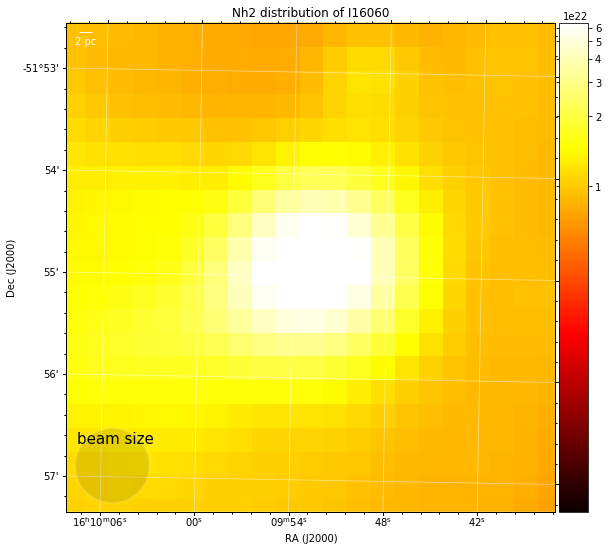

In [31]:
plot_result('Nh2',5.3, 'I16060', center_x=242.4702081, center_y=-51.915194)